# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Pretrained Models from Tensorflow Model Zoo & Install TF Object Detection

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
!pip install Pillow

In [ ]:
!pip install pyyaml

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Import Modules

In [5]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from object_detection.utils import label_map_util
from object_detection.protos import pipeline_pb2
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from google.protobuf import text_format

import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import easyocr

import csv
import uuid

# 3. Create Label Map

In [6]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 4. Create TF records

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!pip install pytz

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 5. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 6. Update Config For Transfer Learning

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 7. Train the model (Generate command to run externally to save the output)

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

# 8. Load Trained Model From Checkpoint

In [7]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    except RunTimeError as e:
        print(e)

In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detection from an Image

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [10]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'test.jpg')

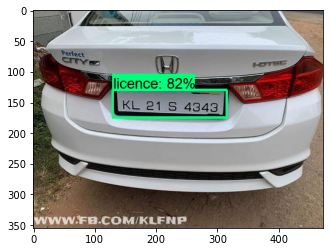

In [11]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}

detections['num_detections'] = num_detections


# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()
image_nobox = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.66,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))

# print(detections['detection_scores'])
plt.show()

In [ ]:
#  detections.keys()

# 10. Apply OCR to Detection

In [ ]:
# !pip install easyocr

In [ ]:
# !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

## OCR Filtering

In [12]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

## Apply OCR

In [13]:
detection_threshold = 0.66
region_threshold = 0.2

In [14]:
def perspective_transform(img, detections, detection_threshold):
    
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    
#     img = cv2.resize(img, (img.shape[0], img.shape[1]))
    width = img.shape[1]
    height = img.shape[0]
    
    for idx, box in enumerate(boxes):
        
        roi = box*[height, width, height, width]
        region = img[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        
        r_width = region.shape[1]
        r_height = region.shape[0]
        
        gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#         blurred = cv2.bilateralFilter(gray, 9, 75, 75)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = contours[0]
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)

        
        # drawing points
        for point in approx:
            x, y = point[0]
            cv2.circle(region, (x, y), 5, (0, 255, 0), -1)

        # drawing skewed rectangle
        cv2.drawContours(region, [approx], -1, (0, 255, 0))
        
#         plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        try:
            x0, y0 = approx[0][0][0], approx[0][0][1]
            x1, y1 = approx[1][0][0], approx[1][0][1]
            x2, y2 = approx[2][0][0], approx[2][0][1]
            x3, y3 = approx[3][0][0], approx[3][0][1]
        except:
            return region,0
        
#         print(x0, y0)
#         print(x1, y1)
#         print(x2, y2)
#         print(x3, y3)
#         cv2.circle(region, (x2, y2), 5, (0, 0, 255), -1)
        pts1 = np.float32([[x0, y0], [x3, y3], [x1, y1], [x2, y2]])
        pts2 = np.float32([[0,0], [r_width,0], [0,r_height], [r_width,r_height]])
        
        pers_matrix = cv2.getPerspectiveTransform(pts1,pts2)
        OutputImg = cv2.warpPerspective(region, pers_matrix, (r_width, r_height))
#         print(type(OutputImg))
           
#     plt.imshow(cv2.cvtColor(OutputImg, cv2.COLOR_BGR2RGB))
    return OutputImg,1

# perspective_transform(image_nobox, detections, detection_threshold)

In [15]:
def perspective_transform_afterROT(img):

#     img = cv2.resize(img, (img.shape[0], img.shape[1]))
    width = img.shape[1]
    height = img.shape[0]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#     blurred = cv2.bilateralFilter(gray, 9, 75, 75)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0]
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)


    # drawing points
    for point in approx:
        x, y = point[0]
        cv2.circle(img, (x, y), 5, (0, 255, 0), -1)

    # drawing skewed rectangle
    cv2.drawContours(img, [approx], -1, (0, 255, 0))

#         plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    try:
        x0, y0 = approx[0][0][0], approx[0][0][1]
        x1, y1 = approx[1][0][0], approx[1][0][1]
        x2, y2 = approx[2][0][0], approx[2][0][1]
        x3, y3 = approx[3][0][0], approx[3][0][1]
    except:
        return img,0

#         print(x0, y0)
#         print(x1, y1)
#         print(x2, y2)
#         print(x3, y3)
#         cv2.circle(region, (x2, y2), 5, (0, 0, 255), -1)
    pts1 = np.float32([[x0, y0], [x3, y3], [x1, y1], [x2, y2]])
    pts2 = np.float32([[0,0], [width,0], [0,height], [width,height]])

    pers_matrix = cv2.getPerspectiveTransform(pts1,pts2)
    OutputImg = cv2.warpPerspective(img, pers_matrix, (width, height))
#         print(type(OutputImg))
           
#     plt.imshow(cv2.cvtColor(OutputImg, cv2.COLOR_BGR2RGB))
    return OutputImg,1

In [16]:
from scipy.ndimage import interpolation as inter

def correct_skew(image, delta=1, limit=1):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
    return best_angle, rotated

In [ ]:
def Hough(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 100, apertureSize = 3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 150, minLineLength=90, maxLineGap=30)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return img

In [ ]:
def apply_ocr(image, image_nobox, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        region_nobox = image_nobox[int(roi[0]-50):int(roi[2]+50),int(roi[1]-50):int(roi[3]+50)]
        
        reader = easyocr.Reader(['en'])
        
        # HOUGH TRANSFORM
#         hough_out = hough(region_nobox)
#         ocr_result = reader.readtext(hough_out)
#         text = filter_text(hough_out, ocr_result, region_threshold)
#         return text, hough_out
        
        # PERSPECTIVE TRANFORMATION METHOD
        flag_inner = 0
        for i in range (0,4):
            Output,result = perspective_transform(image_nobox, detections, detection_threshold)
#         print(type(Output))
            if result == 1:
                ocr_result = reader.readtext(Output)
                text = filter_text(Output, ocr_result, region_threshold)
                if text:
                    flag_inner = 1
                    break
            if flag_inner == 1:
                    break
                    

#         ROATATION METHOD
        flag = 0 
        if not text:
#             print(text)
#             angle, rotated = correct_skew(region_nobox)

            
            
#             gray = cv2.cvtColor(region_nobox, cv2.COLOR_BGR2GRAY)
#             edges = cv2.Canny(gray, 50, 100, apertureSize = 3)
#             lines = cv2.HoughLinesP(edges, 1, np.pi/180, 150, minLineLength=90, maxLineGap=30)
#             for line in lines:
#                 x1, y1, x2, y2 = line[0]
#                 cv2.line(region_nobox, (x1, y1), (x2, y2), (255, 0, 0), 3)
#             plt.imshow(cv2.cvtColor(region_nobox, cv2.COLOR_BGR2RGB))
#             ocr_result = reader.readtext(rotated)
#             text = filter_text(region, ocr_result, region_threshold)

            for i in range (10, 1, -1):
                for j in range (9, 1, -1):
                    angle, rotated = correct_skew(region_nobox,j,i)
                    ocr_result = reader.readtext(rotated)
                    text = filter_text(rotated, ocr_result, region_threshold)
                    if text:
                        flag = 1
#                         print(i,j, text)
                        break
                if flag == 1:
                    break
        
            print(angle)
#         plt.imshow(cv2.cvtColor(Output, cv2.COLOR_BGR2RGB))
        
#         plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))

#         plt.show()
        if flag == 1:
#             rotated = rotated[50:-50, 50:-50]
            flag_inner = 0
            for i in range (0,4):
                rotated_new = rotated.copy()
                rotated_new, result = perspective_transform_afterROT(rotated_new)
        #         print(type(Output))
                if result == 1:
                    ocr_result = reader.readtext(rotated_new)
                    text_new = filter_text(rotated_new, ocr_result, region_threshold)
                    if len("".join(text_new)) >= len("".join(text)) and text_new != text:
                        flag_inner = 1
                        print(yay)
                        return text_new, rotated_new
            return text, rotated
        else:
            return text, Output            

In [ ]:
text, region = apply_ocr(image_np_with_detections, image_nobox, detections, detection_threshold, region_threshold)
plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
print(text)

# 11. Save Results

In [ ]:
# '{}.jpg'.format(uuid.uuid1())

In [ ]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [ ]:
# region

In [ ]:
save_results(text, region, 'detection_results.csv', 'Detection_Images')

# 12. Real Time Detections from your Webcam & Saving it

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        text, region = apply_ocr(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break